# Set Up The Environment

In [1]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, brier_score_loss
import json
import os
import warnings
import requests
from statsbombpy import sb
from tqdm import tqdm


In [2]:
pd.set_option("display.max_columns", None)
data_dir = f"{os.path.abspath(os.path.join(os.getcwd(), '..'))}/data/"

# Suppress the NoAuthWarning from statsbombpy
warnings.filterwarnings("ignore", category=UserWarning, module="statsbombpy")

# Load Data

In [3]:
files = os.listdir(data_dir)
parquet_files = [f for f in files if f.endswith('.parquet')]

# Read and concatenate all parquet files
df_list = [pd.read_parquet(os.path.join(data_dir, f)) for f in parquet_files]
df = pd.concat(df_list, ignore_index=True)

print(f"Loaded {len(df)} rows of data")

Loaded 65127 rows of data


# Prepare Features

In [4]:
def calculate_soft_blocking(shot):
    soft_blocking_value = 0
    goal_blocking_percentage = 0

    if 'shot_freeze_frame' in shot and shot['shot_freeze_frame'] is not None:
        shooter_x, shooter_y = shot['location']
        goal_x, goal_y = 120, 40  # Goal center

        # For each defender, calculate a Gaussian-based blocking influence
        for player in shot['shot_freeze_frame']:
            if player['teammate'] == False and player['position'] != 'Goalkeeper':
                defender_x, defender_y = player['location']

                # Distance from defender to shot line
                # Calculate perpendicular distance to shot-goal line
                line_vector = [goal_x - shooter_x, goal_y - shooter_y]
                line_length = np.sqrt(line_vector[0]**2 + line_vector[1]**2)
                normalized_line = [line_vector[0]/line_length, line_vector[1]/line_length]

                # Vector from shooter to defender
                defender_vector = [defender_x - shooter_x, defender_y - shooter_y]

                # Dot product for projection
                projection_length = defender_vector[0]*normalized_line[0] + defender_vector[1]*normalized_line[1]

                # Only consider defenders between shooter and goal
                if 0 < projection_length < line_length:
                    # Calculate perpendicular distance
                    projection_point = [shooter_x + normalized_line[0]*projection_length,
                                       shooter_y + normalized_line[1]*projection_length]
                    perp_distance = np.sqrt((defender_x - projection_point[0])**2 +
                                           (defender_y - projection_point[1])**2)

                    # Gaussian influence (1 at center, decaying with distance)
                    sigma = 1.5  # Controls how quickly blocking influence decays
                    blocking_influence = np.exp(-(perp_distance**2)/(2*sigma**2))

                    soft_blocking_value += blocking_influence

                    # Calculate goal face occlusion percentage (simplified)
                    # This is a very simplified approach - a complete implementation would 
                    # calculate actual goal area occlusion
                    angle_to_goal = np.arctan2(goal_y - shooter_y, goal_x - shooter_x)
                    angle_to_defender = np.arctan2(defender_y - shooter_y, defender_x - shooter_x)
                    angle_diff = abs(angle_to_goal - angle_to_defender)
                    if angle_diff < 0.3:  # ~17 degrees threshold
                        goal_blocking_percentage += blocking_influence * 0.2  # Assume each defender blocks ~20% max

    return soft_blocking_value, min(goal_blocking_percentage, 1.0)  # Cap at 100%

In [5]:
# We need to extract relevant features from the shot data
def extract_shot_features(shots_df):
    features = []

    for _, shot in shots_df.iterrows():
        # Basic location info
        x = shot['location'][0]
        y = shot['location'][1]

        # Calculate distance and angle to goal
        # Pitch dimensions: 120 x 80 in StatsBomb coordinates
        distance = np.sqrt((x - 120)**2 + (y - 40)**2)
        angle = np.abs(np.arctan2(y - 40, 120 - x))

        # Shot outcome (our target variable)
        outcome = 1 if shot['shot_outcome'] == 'Goal' else 0

        # Other features
        body_part = shot['shot_body_part'] if 'shot_body_part' in shot else 'Unknown'
        shot_type = shot['shot_type'] if 'shot_type' in shot else 'Unknown'
        technique = shot['shot_technique'] if 'shot_technique' in shot else 'Unknown'
        shot_one_on_one = shot['shot_one_on_one'] if 'shot_one_on_one' in shot else 'Unknown'

        # More advanced features (if available)
        under_pressure = 1 if 'under_pressure' in shot and shot['under_pressure'] else 0
        first_time = 1 if 'shot_first_time' in shot and shot['shot_first_time'] else 0

        # Game period categories
        minute = shot.get('minute', 0)
        if minute < 15:
            game_period = 'Opening'
        elif minute < 40:
            game_period = 'First Half'
        elif minute < 45:
            game_period = 'First Half Ending'
        elif minute < 60:
            game_period = 'Second Half Beginning'
        elif minute < 80:
            game_period = 'Second Half'
        else:
            game_period = 'Closing Minutes'

        # FEATURE: Defender positions
        # Count defenders between shot and goal, and find closest defender
        defenders_in_path = 0
        min_defender_distance = 100  # Initialize with large value

        # Get freeze frame if available
        if 'shot_freeze_frame' in shot and shot['shot_freeze_frame'] is not None:
            freeze_frame = shot['shot_freeze_frame']

            # Goal coordinates
            goal_x = 120
            goal_y = 40

            for player in freeze_frame:
                if player['teammate'] == False and player['position'] != 'Goalkeeper':
                    # Check if defender is between shot and goal
                    player_x = player['location'][0]
                    player_y = player['location'][1]

                    # Simple check - if defender is in the "cone" from shot to goal
                    if player_x > x:  # Defender is closer to goal than shooter
                        # Calculate if defender is in path (simplified approach)
                        shot_to_goal_angle = np.arctan2(goal_y - y, goal_x - x)
                        shot_to_defender_angle = np.arctan2(player_y - y, player_x - x)

                        # If angles are close, defender is in path
                        if abs(shot_to_goal_angle - shot_to_defender_angle) < 0.3:  # ~17 degrees
                            defenders_in_path += 1

                    # Calculate distance to nearest defender
                    defender_distance = np.sqrt((player_x - x)**2 + (player_y - y)**2)
                    min_defender_distance = min(min_defender_distance, defender_distance)
        # IF we don't have a freeze frame, we will impute the values later
        else:
            defenders_in_path = None
            min_defender_distance = None

        if min_defender_distance == 100:  # No defenders found
            min_defender_distance = 20

        # Blocking features
        soft_blocking, goal_blocking_percentage = calculate_soft_blocking(shot)

        # NEW FEATURE 4: Goalkeeper position
        gk_distance = 15  # Default value
        gk_angle = 0  # Default value

        if 'shot_freeze_frame' in shot and shot['shot_freeze_frame'] is not None:
            for player in shot['shot_freeze_frame']:
                if player['teammate'] == False and player['position']['name'] == 'Goalkeeper':
                    gk_x = player['location'][0]
                    gk_y = player['location'][1]

                    # Distance from shooter to goalkeeper
                    gk_distance = np.sqrt((gk_x - x)**2 + (gk_y - y)**2)
                    # Distance from goalkeeper to goal line
                    gk_goal_line_distance = 120 - gk_x

                    # Angle between shot trajectory and goalkeeper
                    shot_to_goal_angle = np.arctan2(40 - y, 120 - x)
                    shot_to_gk_angle = np.arctan2(gk_y - y, gk_x - x)
                    gk_angle = abs(shot_to_goal_angle - shot_to_gk_angle)
        # IF we don't have a freeze frame, we will impute the values later
        else:
            gk_distance = None
            gk_angle = None

        features.append({
            'x': x,
            'y': y,
            'distance': distance,
            'angle': angle,
            'body_part': body_part,
            'shot_type': shot_type,
            'technique': technique,
            'shot_one_on_one': shot_one_on_one,
            'under_pressure': under_pressure,
            'first_time': first_time,
            # New features
            'minute': minute,
            'game_period': game_period,
            'defenders_in_path': defenders_in_path,
            'min_defender_distance': min_defender_distance,
            'soft_blocking': soft_blocking,
            'goal_blocking_percentage': goal_blocking_percentage,
            'gk_distance': gk_distance,
            'gk_angle': gk_angle,
            'gk_goal_line_distance': gk_goal_line_distance,
            # Result
            'goal': outcome
        })


    return pd.DataFrame(features)

# XGBoost Model

## Setup XGBoost

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error, log_loss

## Train both models using grid search

In [ ]:
# Prepare the data (assuming you've already created X_train, X_test, y_train, y_test)

# 1. Logistic Regression with hyperparameter tuning
log_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'max_iter': [2000],
    'class_weight': [None, 'balanced']
}

log_grid_search = GridSearchCV(
    LogisticRegression(max_iter=2000),
    param_grid=log_param_grid,
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

log_grid_search.fit(X_train, y_train)
log_model = log_grid_search.best_estimator_

print(f"Best Logistic Regression parameters: {log_grid_search.best_params_}")
print(f"Best CV ROC-AUC: {log_grid_search.best_score_:.4f}")

# 2. XGBoost with hyperparameter tuning
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# For a quicker initial run, you can use a smaller grid:
# xgb_param_grid_small = {
#     'n_estimators': [100, 200],
#     'max_depth': [3, 5],
#     'learning_rate': [0.05, 0.1],
#     'subsample': [0.8],
# }

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
)

xgb_grid_search = GridSearchCV(
    xgb_model,
    param_grid=xgb_param_grid,  # Use the smaller grid for initial testing
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(X_train, y_train)
xgb_best = xgb_grid_search.best_estimator_

print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")
print(f"Best CV ROC-AUC: {xgb_grid_search.best_score_:.4f}")

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best Logistic Regression parameters: {'C': 10, 'class_weight': 'balanced', 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV ROC-AUC: 0.8238
Fitting 4 folds for each of 729 candidates, totalling 2916 fits
Best XGBoost parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}
Best CV ROC-AUC: 0.8275


## Evaluate the models

                 Model   ROC AUC  Brier Score  Log Loss
0  Logistic Regression  0.819005     0.168831  0.514829
1              XGBoost  0.821664     0.076948  0.268466
2            StatsBomb  0.819741     0.077235  0.270195


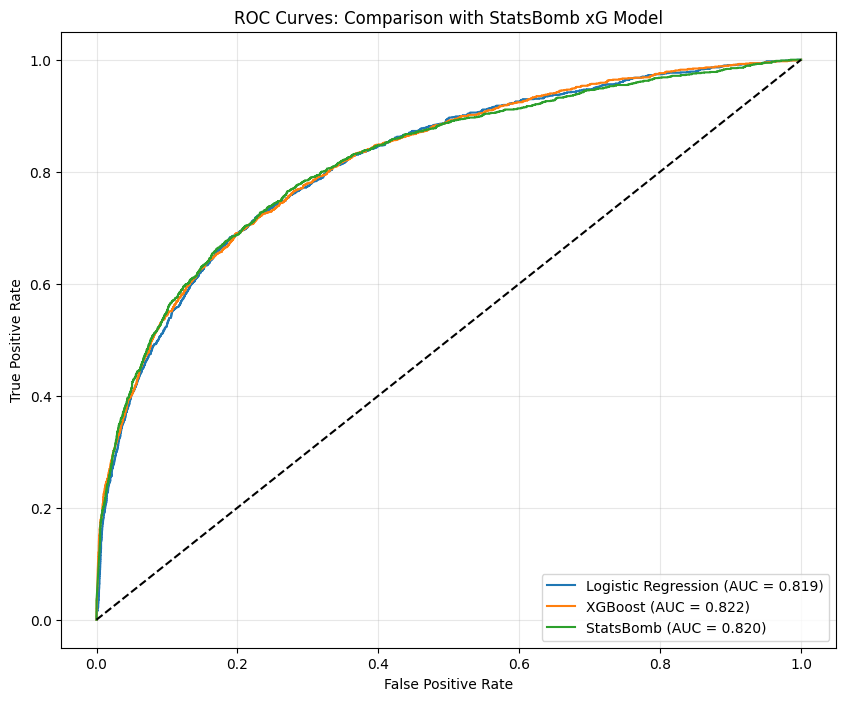

In [ ]:
# Make predictions with both models
log_pred_proba = log_model.predict_proba(X_test)[:, 1]
xgb_pred_proba = xgb_best.predict_proba(X_test)[:, 1]

# Compare with StatsBomb's xG model
# First, we need to get the StatsBomb xG values for our test set
# We'll match the test indices back to the original dataframe

# Create mapping from shot features to original data
# Assuming indices in shot_features correspond to df
test_indices = y_test.index
sb_xg_test = df.iloc[test_indices]['shot_statsbomb_xg'].values
sb_xg_test = np.clip(sb_xg_test, 0.001, 0.999)  # Clip to avoid log(0) errors

# Calculate metrics for StatsBomb model
sb_roc_auc = roc_auc_score(y_test, sb_xg_test)
sb_brier = brier_score_loss(y_test, sb_xg_test)
sb_log_loss = log_loss(y_test, sb_xg_test)

# Add StatsBomb metrics to comparison dataframe
metrics_with_sb = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'StatsBomb'],
    'ROC AUC': [roc_auc_score(y_test, log_pred_proba), 
                roc_auc_score(y_test, xgb_pred_proba),
                sb_roc_auc],
    'Brier Score': [brier_score_loss(y_test, log_pred_proba), 
                    brier_score_loss(y_test, xgb_pred_proba),
                    sb_brier],
    'Log Loss': [log_loss(y_test, log_pred_proba), 
                log_loss(y_test, xgb_pred_proba),
                sb_log_loss]
})

print(metrics_with_sb)

# Plot ROC curves with StatsBomb included
plt.figure(figsize=(10, 8))

# ROC for Logistic Regression
fpr_log, tpr_log, _ = roc_curve(y_test, log_pred_proba)
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, log_pred_proba):.3f})')

# ROC for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_pred_proba):.3f})')

# ROC for StatsBomb
fpr_sb, tpr_sb, _ = roc_curve(y_test, sb_xg_test)
plt.plot(fpr_sb, tpr_sb, label=f'StatsBomb (AUC = {sb_roc_auc:.3f})')

# Reference line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Comparison with StatsBomb xG Model')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## Compare Calibration Curves

Calibration is especially important for xG models since we want the predicted probabilities to accurately reflect actual goal frequencies:

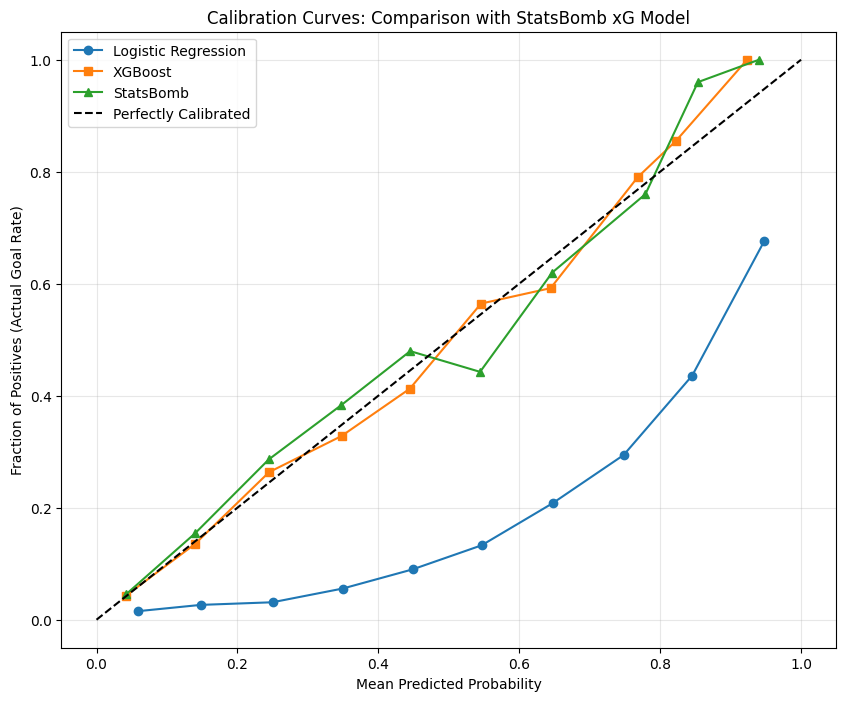

In [ ]:
# Calibration curve comparison
plt.figure(figsize=(10, 8))

# Calibration curve for Logistic Regression
prob_true_log, prob_pred_log = calibration_curve(y_test, log_pred_proba, n_bins=10)
plt.plot(prob_pred_log, prob_true_log, marker='o', label=f'Logistic Regression')

# Calibration curve for XGBoost
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, xgb_pred_proba, n_bins=10)
plt.plot(prob_pred_xgb, prob_true_xgb, marker='s', label=f'XGBoost')

# Calibration curve for StatsBomb
prob_true_sb, prob_pred_sb = calibration_curve(y_test, sb_xg_test, n_bins=10)
plt.plot(prob_pred_sb, prob_true_sb, marker='^', label=f'StatsBomb')

# Perfect calibration
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives (Actual Goal Rate)')
plt.title('Calibration Curves: Comparison with StatsBomb xG Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Analyze Feature Importance

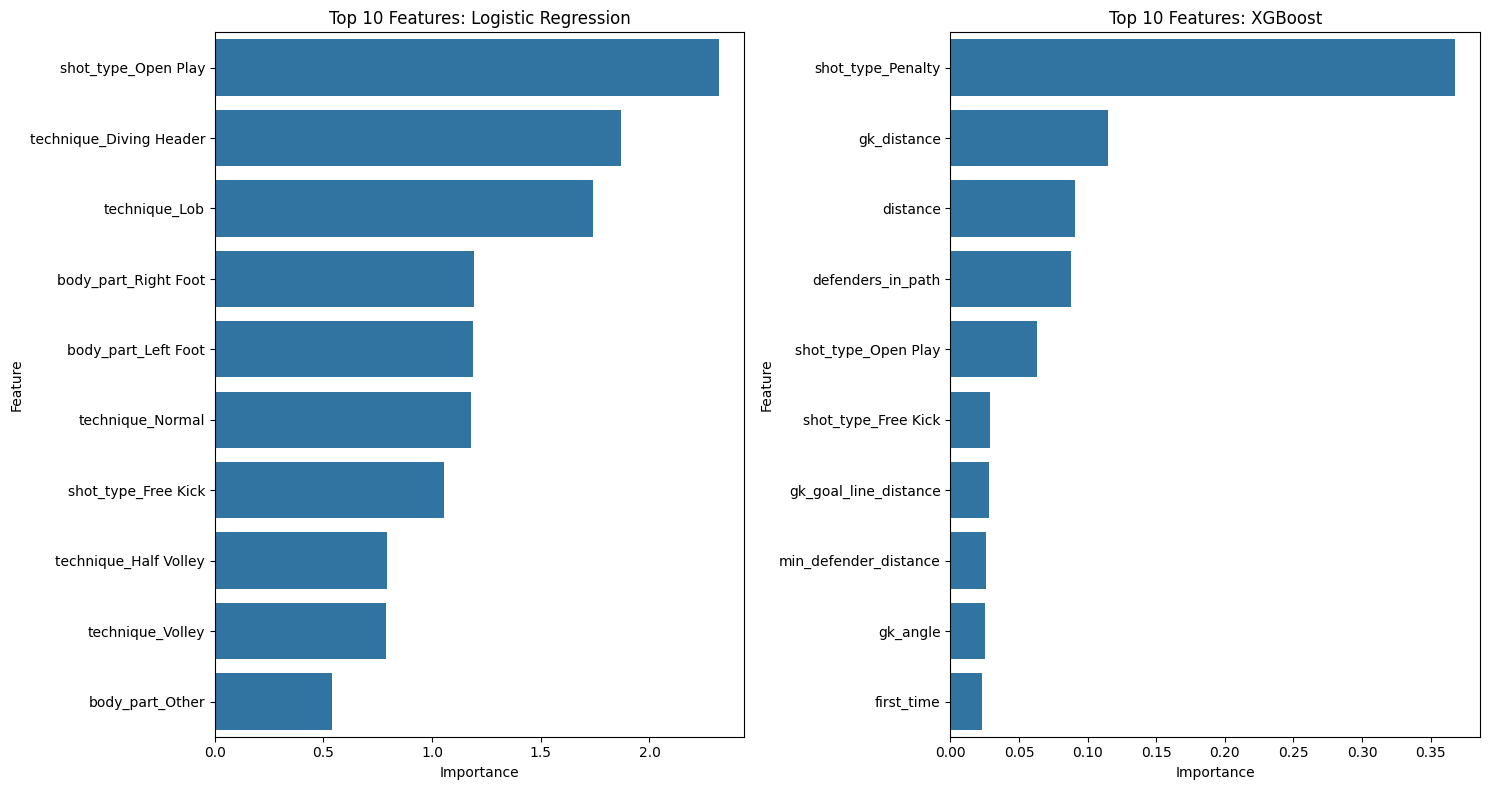

In [ ]:
# Feature importance for Logistic Regression
log_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(log_model.coef_[0])
})
log_importance = log_importance.sort_values('Importance', ascending=False)

# Feature importance for XGBoost
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_best.feature_importances_
})
xgb_importance = xgb_importance.sort_values('Importance', ascending=False)

# Plot feature importances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Logistic Regression
top_features_log = log_importance.head(10)
sns.barplot(x='Importance', y='Feature', data=top_features_log, ax=ax1)
ax1.set_title('Top 10 Features: Logistic Regression')

# XGBoost
top_features_xgb = xgb_importance.head(10)
sns.barplot(x='Importance', y='Feature', data=top_features_xgb, ax=ax2)
ax2.set_title('Top 10 Features: XGBoost')

plt.tight_layout()
plt.show()

### Analsis with SHAP

SHAP (SHapley Additive exPlanations) values are used to get a deeper understanding of your xG model's feature importance. SHAP provides more nuanced insights into how each feature contributes to predictions than traditional feature importance methods.

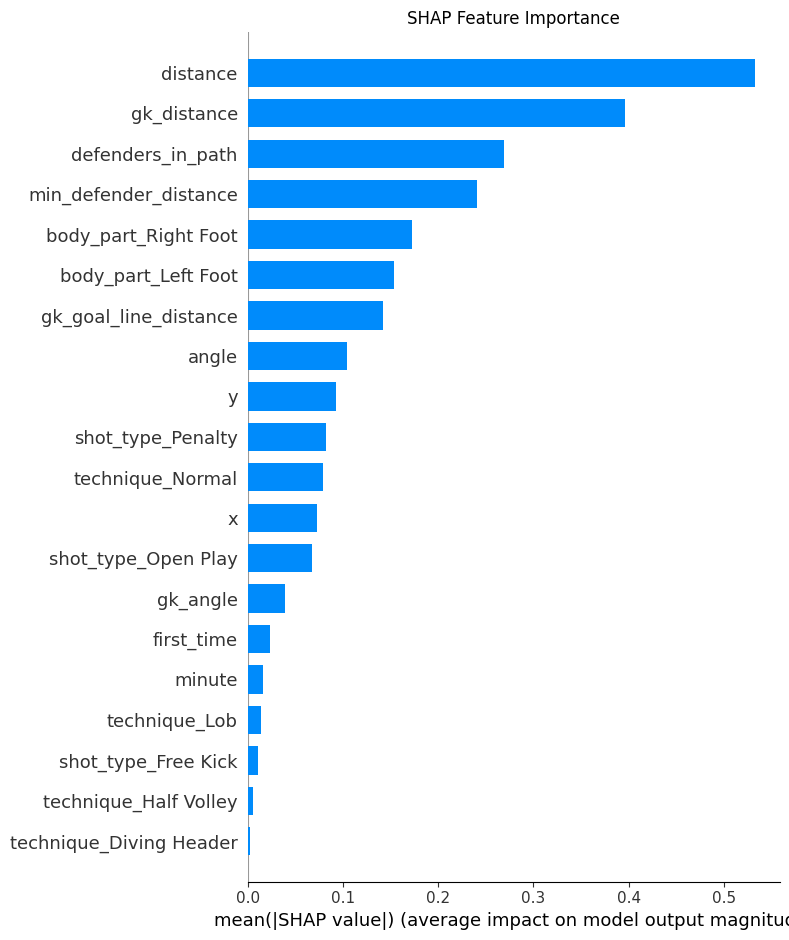

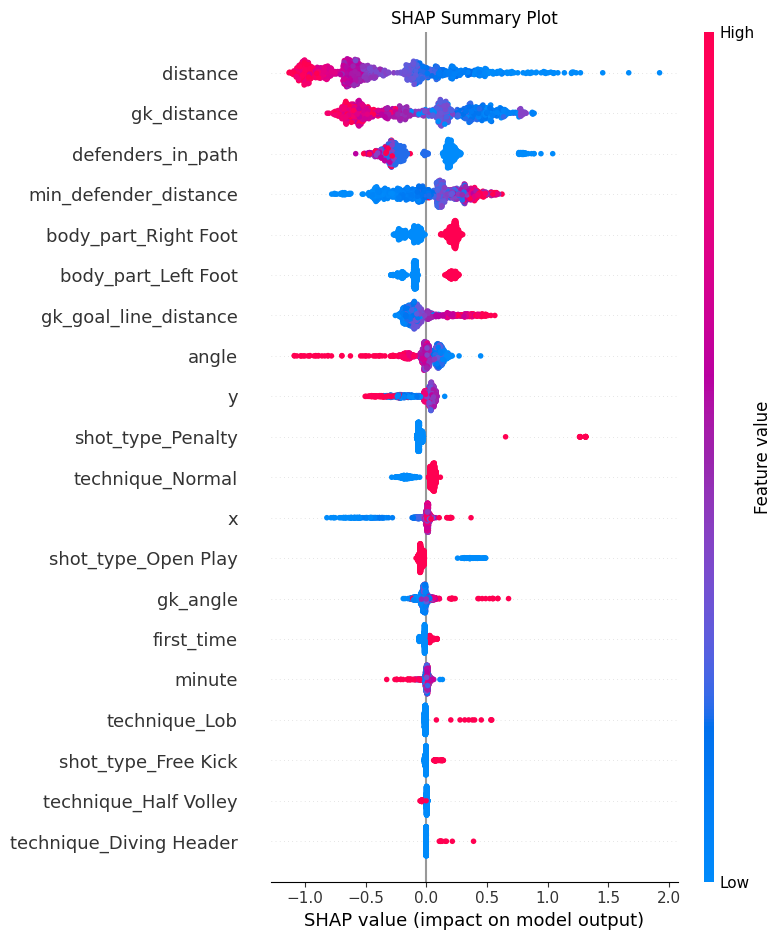

<Figure size 1000x700 with 0 Axes>

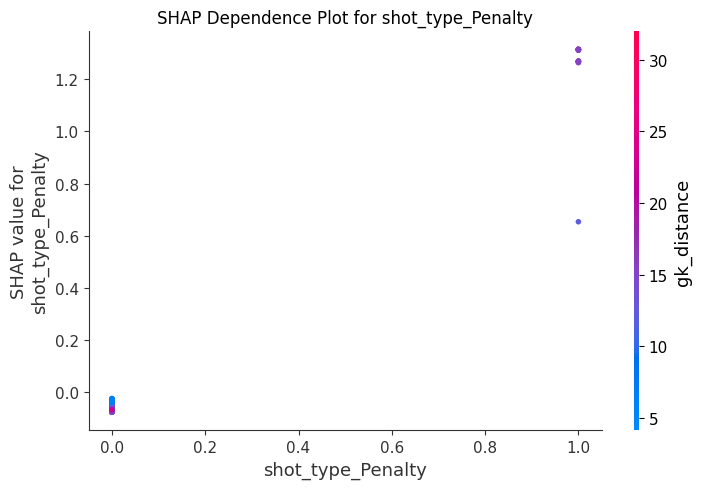

<Figure size 1000x700 with 0 Axes>

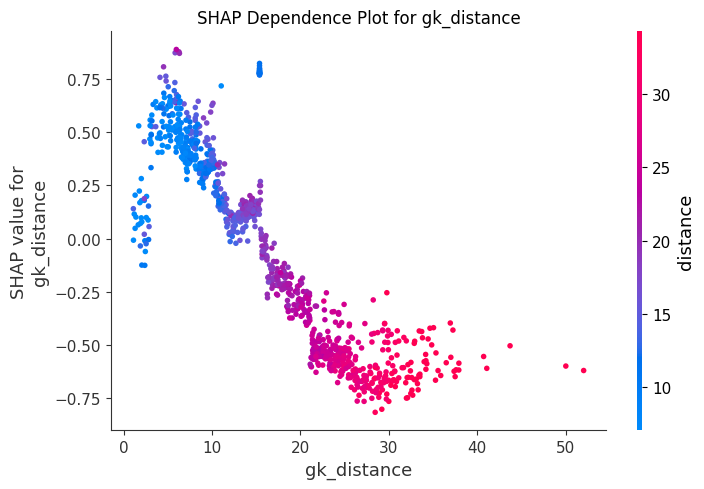

<Figure size 1000x700 with 0 Axes>

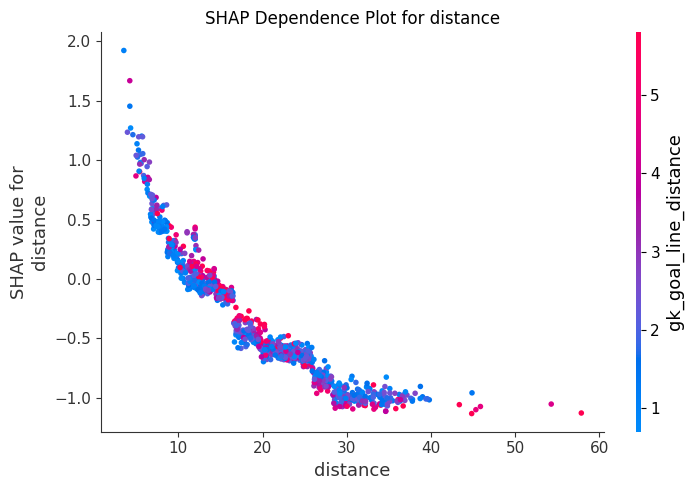

<Figure size 2000x300 with 0 Axes>

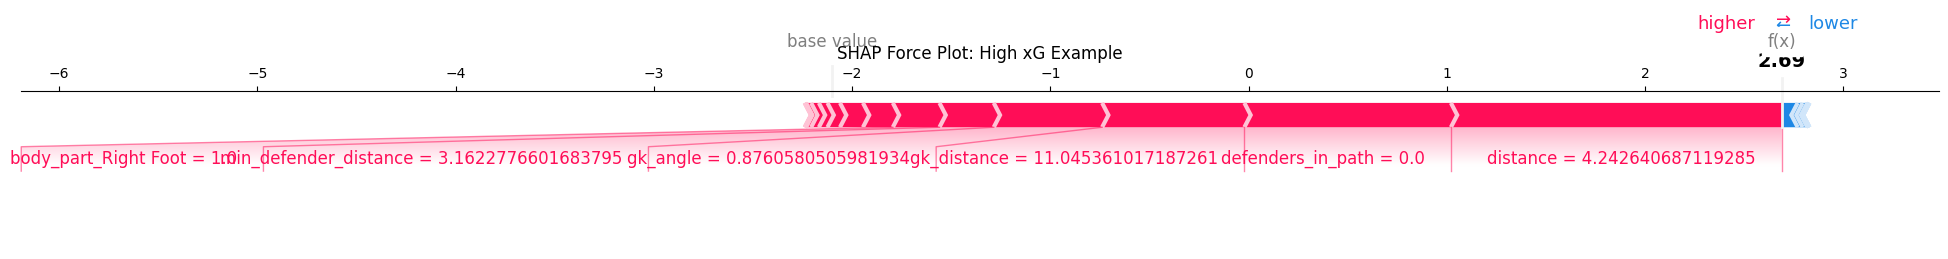

<Figure size 2000x300 with 0 Axes>

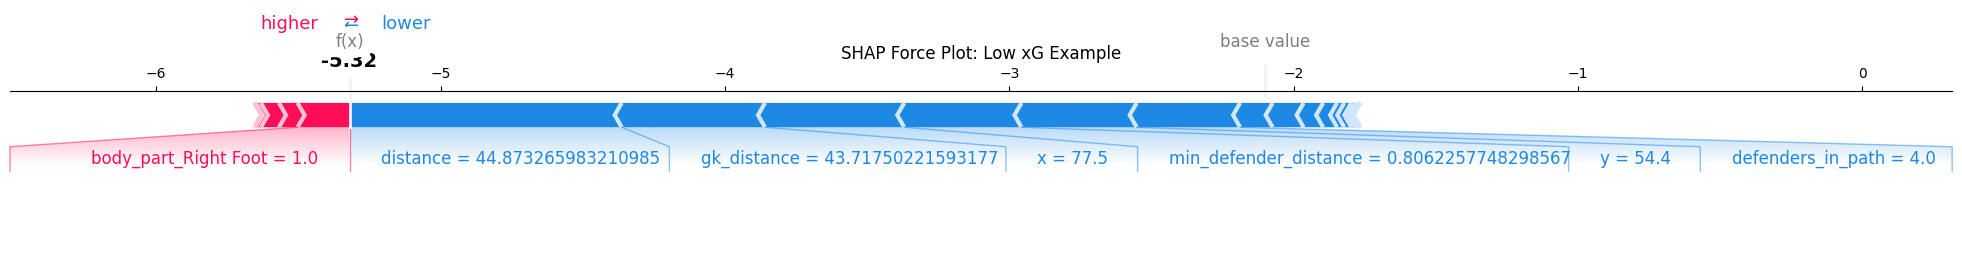

<Figure size 2000x300 with 0 Axes>

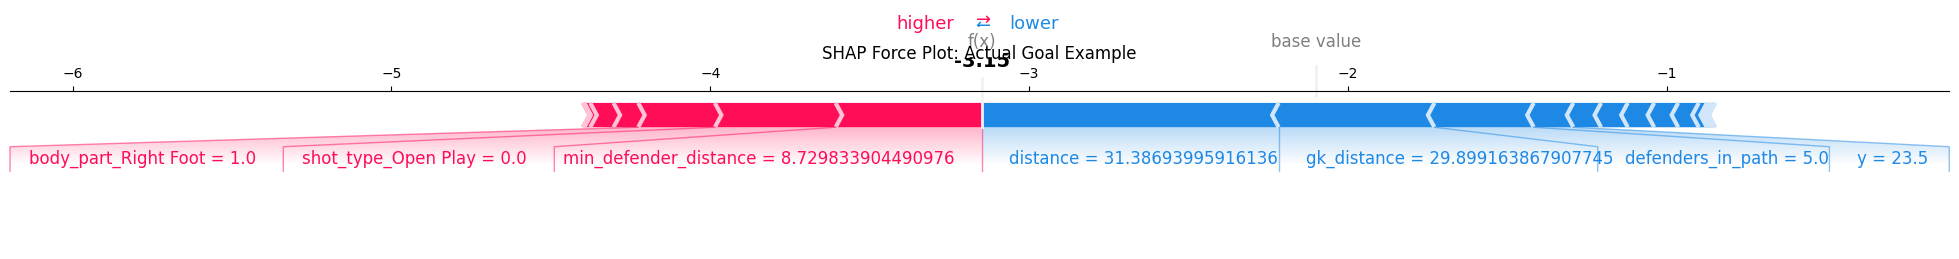

In [ ]:
# Import SHAP
import shap

# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(xgb_best)

# Calculate SHAP values on a sample of the test set (for speed)
sample_size = min(1000, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_test_sample = X_test.iloc[sample_indices]
shap_values = explainer(X_test_sample)

# Create a summary plot showing the impact of each feature
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Create a summary plot showing both feature importance and effect direction
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

# Detailed dependence plots for top 3 features
# Find the indices of the top 3 features from the XGBoost importance
top_feature_indices = xgb_importance.head(3)['Feature'].values
for feature in top_feature_indices:
    plt.figure(figsize=(10, 7))
    shap.dependence_plot(feature, shap_values.values, X_test_sample, show=False)
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()

# Force plot for a few example predictions
# High xG example
high_xg_idx = np.argmax(xgb_pred_proba[sample_indices])
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, 
                shap_values[high_xg_idx].values, 
                X_test_sample.iloc[high_xg_idx],
                matplotlib=True, show=False)
plt.title("SHAP Force Plot: High xG Example")
plt.tight_layout()
plt.show()

# Low xG example
low_xg_idx = np.argmin(xgb_pred_proba[sample_indices])
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, 
                shap_values[low_xg_idx].values, 
                X_test_sample.iloc[low_xg_idx],
                matplotlib=True, show=False)
plt.title("SHAP Force Plot: Low xG Example")
plt.tight_layout()
plt.show()

# Compare with a goal that was actually scored
goal_indices = np.where(y_test.iloc[sample_indices] == 1)[0]
if len(goal_indices) > 0:
    scored_goal_idx = goal_indices[0]
    plt.figure(figsize=(20, 3))
    shap.force_plot(explainer.expected_value, 
                    shap_values[scored_goal_idx].values, 
                    X_test_sample.iloc[scored_goal_idx],
                    matplotlib=True, show=False)
    plt.title("SHAP Force Plot: Actual Goal Example")
    plt.tight_layout()
    plt.show()

## Compare xG Heatmaps

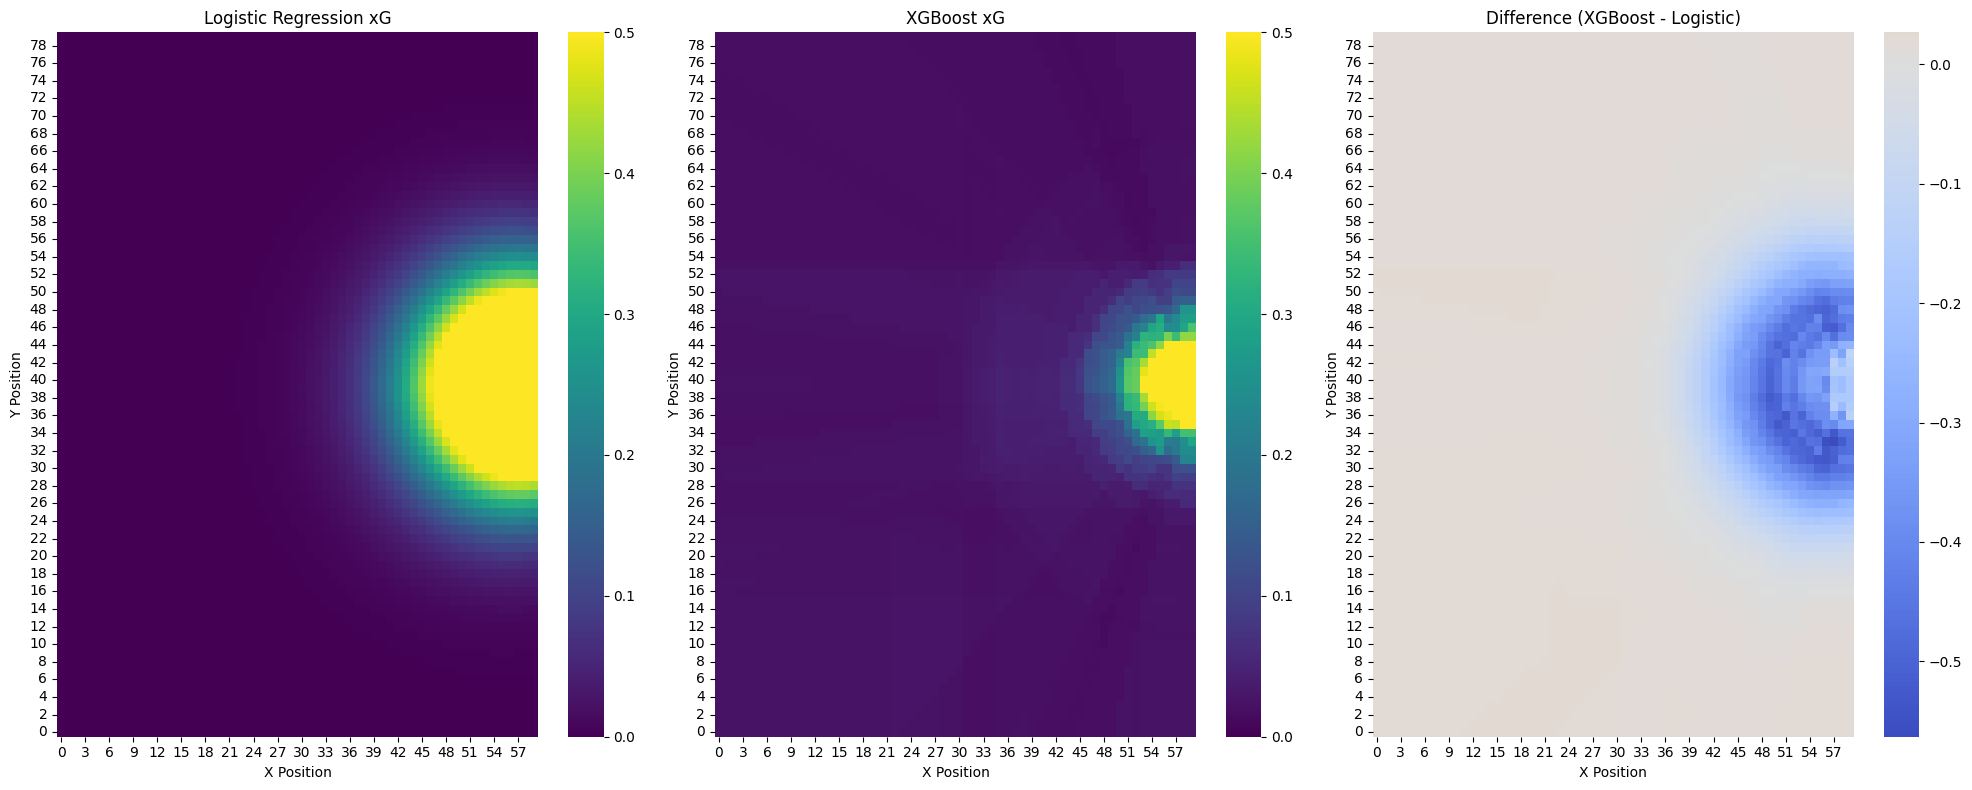

In [ ]:
def plot_xg_model_comparison(log_model, xgb_model):
    # Create a grid of pitch locations
    x_grid = np.linspace(60, 120, 60)  # Only attacking half
    y_grid = np.linspace(0, 80, 80)
    xx, yy = np.meshgrid(x_grid, y_grid)

    # Calculate features for each point
    grid_points = []
    for x, y in zip(xx.flatten(), yy.flatten()):
        distance = np.sqrt((x - 120)**2 + (y - 40)**2)
        angle = np.abs(np.arctan2(y - 40, 120 - x))

        # Same feature setup as before
        grid_points.append({
            'x': x,
            'y': y,
            'distance': distance,
            'angle': angle,
            'under_pressure': 0,  # Assumptions for visualization
            'first_time': 0,
            'body_part_Foot': 1,  # Assuming right foot shot
            'body_part_Head': 0,
            'shot_type_Open Play': 1,
            'technique_Normal': 1,
            'game_period_First Half': 1,
            'defenders_in_path': 2.0,
            'min_defender_distance': 2.3430749027719995,
            'gk_distance': 15.376930773076923,
            'gk_angle': 0.034879005766847326,
            'gk_goal_line_distance': 2.0
        })

    grid_df = pd.DataFrame(grid_points)

    # Match columns with training data
    missing_cols = set(X.columns) - set(grid_df.columns)
    for col in missing_cols:
        grid_df[col] = 0

    grid_df = grid_df[X.columns]

    # Predict xG with both models
    log_xg_values = log_model.predict_proba(grid_df)[:, 1]
    xgb_xg_values = xgb_model.predict_proba(grid_df)[:, 1]
    diff_xg_values = xgb_xg_values - log_xg_values

    # Reshape for heatmaps
    log_xg_grid = log_xg_values.reshape(len(y_grid), len(x_grid))
    xgb_xg_grid = xgb_xg_values.reshape(len(y_grid), len(x_grid))
    diff_xg_grid = diff_xg_values.reshape(len(y_grid), len(x_grid))

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))

    # Logistic Regression
    sns.heatmap(log_xg_grid, cmap='viridis', vmin=0, vmax=0.5, ax=axes[0])
    axes[0].set_title('Logistic Regression xG')
    axes[0].set_xlabel('X Position')
    axes[0].set_ylabel('Y Position')
    axes[0].invert_yaxis()

    # XGBoost
    sns.heatmap(xgb_xg_grid, cmap='viridis', vmin=0, vmax=0.5, ax=axes[1])
    axes[1].set_title('XGBoost xG')
    axes[1].set_xlabel('X Position')
    axes[1].set_ylabel('Y Position')
    axes[1].invert_yaxis()

    # Difference
    sns.heatmap(diff_xg_grid, cmap='coolwarm', center=0, ax=axes[2])
    axes[2].set_title('Difference (XGBoost - Logistic)')
    axes[2].set_xlabel('X Position')
    axes[2].set_ylabel('Y Position')
    axes[2].invert_yaxis()

    plt.tight_layout()
    plt.show()

# Compare the models visually
plot_xg_model_comparison(log_model, xgb_best)

In [ ]:
shot_features['shot_one_on_one'] = 1 if shot_features['shot_one_on_one'] == 'True' else 0

In [ ]:
shot_features['shot_one_on_one'].value_counts()

shot_one_on_one
0    65127
Name: count, dtype: int64

In [20]:
shot_features = extract_shot_features(df)

In [30]:
# Calculate mean values for imputation
defenders_in_path_mean = shot_features['defenders_in_path'].median()
min_defender_distance_mean = shot_features['min_defender_distance'].median()
gk_distance_mean = shot_features['gk_distance'].median()
gk_angle_mean = shot_features['gk_angle'].median()
gk_goal_line_distance_mean = shot_features['gk_goal_line_distance'].median()
soft_blocking_mean = shot_features['soft_blocking'].median()
goal_blocking_percentage_mean = shot_features['goal_blocking_percentage'].median()

print(f"Defenders in path: {defenders_in_path_mean}")
print(f"Min defender distance: {min_defender_distance_mean}")
print(f"GK distance: {gk_distance_mean}")
print(f"GK goal line distance: {gk_goal_line_distance_mean}")
print(f"GK angle: {gk_angle_mean}")
print(f"Soft blocking: {soft_blocking_mean}")
print(f"Goal blocking percentage: {goal_blocking_percentage_mean}")

# Fill missing values using DataFrame's fillna with a dictionary
shot_features.fillna({
    'defenders_in_path': defenders_in_path_mean,
    'min_defender_distance': min_defender_distance_mean,
    'gk_distance': gk_distance_mean,
    'gk_angle': gk_angle_mean,
    'gk_goal_line_distance': gk_goal_line_distance_mean,
    'soft_blocking': soft_blocking_mean,
    'goal_blocking_percentage': goal_blocking_percentage_mean
}, inplace=True)

shot_features['shot_one_on_one'] = shot_features['shot_one_on_one'].fillna(0)
shot_features['shot_one_on_one'] = shot_features['shot_one_on_one'].astype(int)

Defenders in path: 2.0
Min defender distance: 2.3430749027719995
GK distance: 15.376930773076923
GK goal line distance: 2.0
GK angle: 0.034879005766847326
Soft blocking: 2.0135712071627707
Goal blocking percentage: 0.33964636191426956


# Prepare Training Data

In [31]:
# Handle categorical variables
shot_features_processed = pd.get_dummies(shot_features, columns=['body_part', 'shot_type', 'technique', 'game_period'], drop_first=True)

# Split data
X = shot_features_processed.drop('goal', axis=1)
y = shot_features_processed['goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Analysis of features

# XGBoost Model

## Setup XGBoost

In [32]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.calibration import calibration_curve
from sklearn.metrics import mean_squared_error, log_loss

## Train both models using grid search

In [35]:
# Prepare the data (assuming you've already created X_train, X_test, y_train, y_test)
# Update XGBoost parameters with monotonic constraints
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
)

xgb_grid_search = GridSearchCV(
    xgb_model,
    param_grid=xgb_param_grid,  # Use the smaller grid for initial testing
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(X_train, y_train)
xgb_best = xgb_grid_search.best_estimator_

print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")
print(f"Best CV ROC-AUC: {xgb_grid_search.best_score_:.4f}")

Fitting 4 folds for each of 729 candidates, totalling 2916 fits
Best XGBoost parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV ROC-AUC: 0.8288


## Evaluate the models

       Model   ROC AUC  Brier Score  Log Loss
0    XGBoost  0.823727     0.076760  0.267420
1  StatsBomb  0.819741     0.077235  0.270195


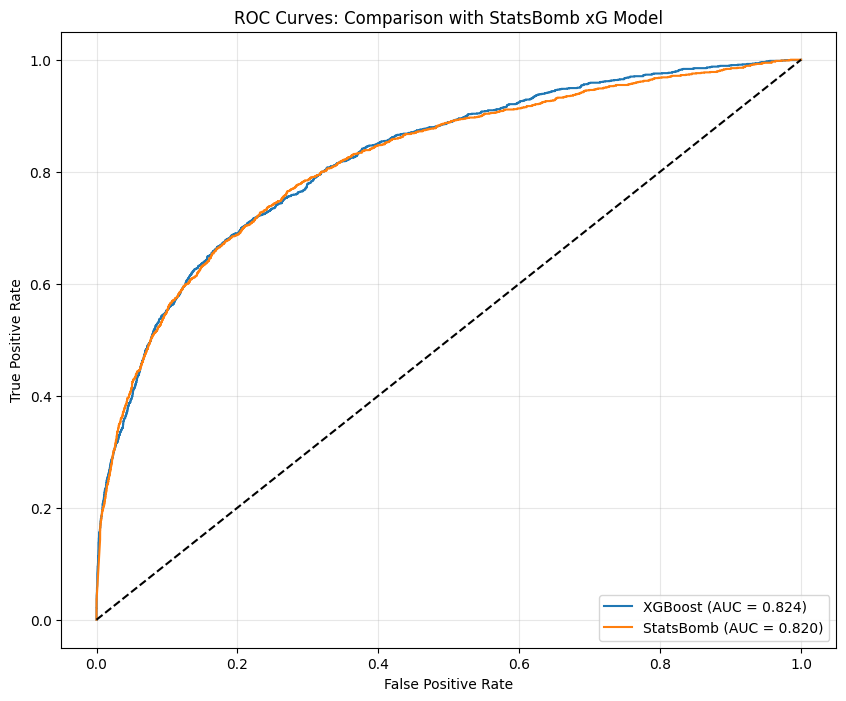

In [36]:
# Make predictions with both models
xgb_pred_proba = xgb_best.predict_proba(X_test)[:, 1]

# Compare with StatsBomb's xG model
# First, we need to get the StatsBomb xG values for our test set
# We'll match the test indices back to the original dataframe

# Create mapping from shot features to original data
# Assuming indices in shot_features correspond to df
test_indices = y_test.index
sb_xg_test = df.iloc[test_indices]['shot_statsbomb_xg'].values
sb_xg_test = np.clip(sb_xg_test, 0.001, 0.999)  # Clip to avoid log(0) errors

# Calculate metrics for StatsBomb model
sb_roc_auc = roc_auc_score(y_test, sb_xg_test)
sb_brier = brier_score_loss(y_test, sb_xg_test)
sb_log_loss = log_loss(y_test, sb_xg_test)

# Add StatsBomb metrics to comparison dataframe
metrics_with_sb = pd.DataFrame({
    'Model': ['XGBoost', 'StatsBomb'],
    'ROC AUC': [roc_auc_score(y_test, xgb_pred_proba),
                sb_roc_auc],
    'Brier Score': [brier_score_loss(y_test, xgb_pred_proba), 
                    sb_brier],
    'Log Loss': [log_loss(y_test, xgb_pred_proba), 
                sb_log_loss]
})

print(metrics_with_sb)

# Plot ROC curves with StatsBomb included
plt.figure(figsize=(10, 8))

# ROC for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_proba)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_score(y_test, xgb_pred_proba):.3f})')

# ROC for StatsBomb
fpr_sb, tpr_sb, _ = roc_curve(y_test, sb_xg_test)
plt.plot(fpr_sb, tpr_sb, label=f'StatsBomb (AUC = {sb_roc_auc:.3f})')

# Reference line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Comparison with StatsBomb xG Model')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

## Compare Calibration Curves

Calibration is especially important for xG models since we want the predicted probabilities to accurately reflect actual goal frequencies:

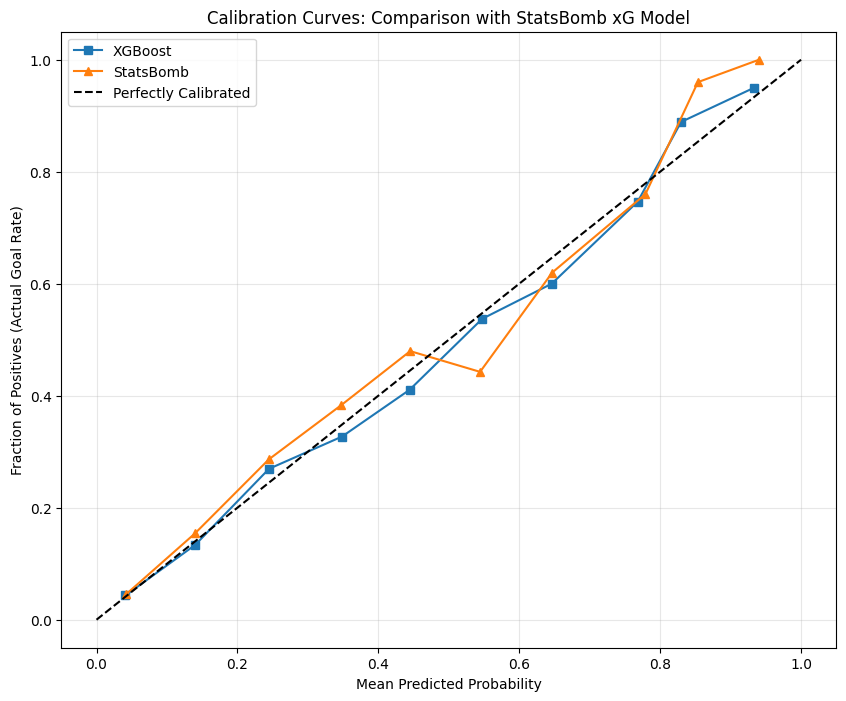

In [37]:
# Calibration curve comparison
plt.figure(figsize=(10, 8))

# Calibration curve for XGBoost
prob_true_xgb, prob_pred_xgb = calibration_curve(y_test, xgb_pred_proba, n_bins=10)
plt.plot(prob_pred_xgb, prob_true_xgb, marker='s', label=f'XGBoost')

# Calibration curve for StatsBomb
prob_true_sb, prob_pred_sb = calibration_curve(y_test, sb_xg_test, n_bins=10)
plt.plot(prob_pred_sb, prob_true_sb, marker='^', label=f'StatsBomb')

# Perfect calibration
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives (Actual Goal Rate)')
plt.title('Calibration Curves: Comparison with StatsBomb xG Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Analyze Feature Importance

### Analsis with SHAP

SHAP (SHapley Additive exPlanations) values are used to get a deeper understanding of your xG model's feature importance. SHAP provides more nuanced insights into how each feature contributes to predictions than traditional feature importance methods.

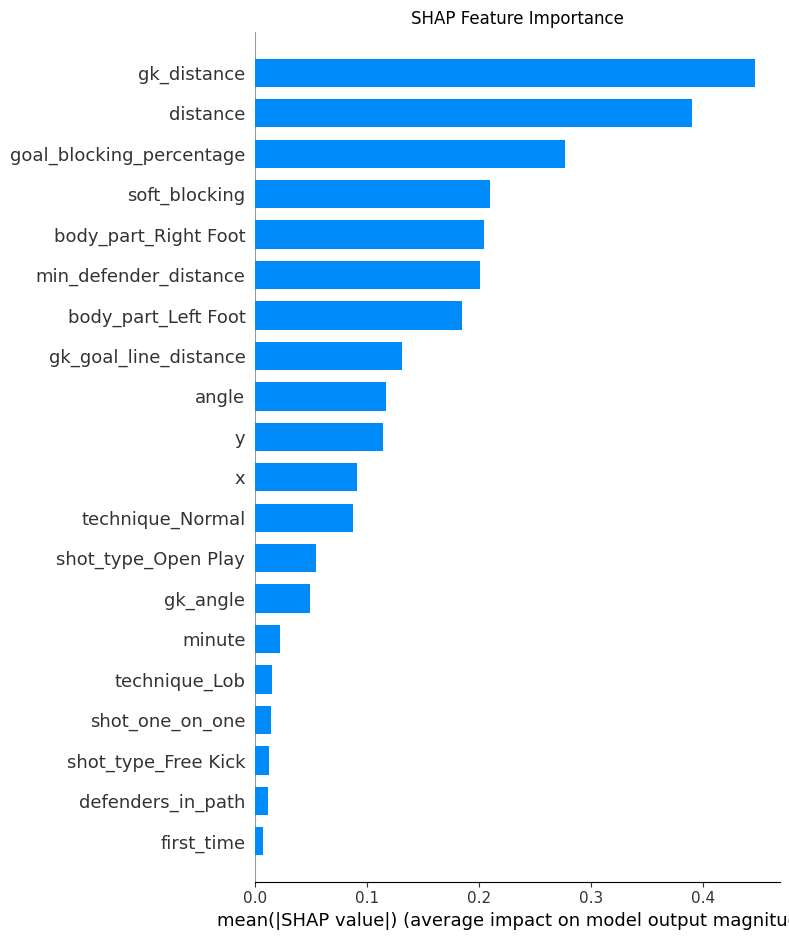

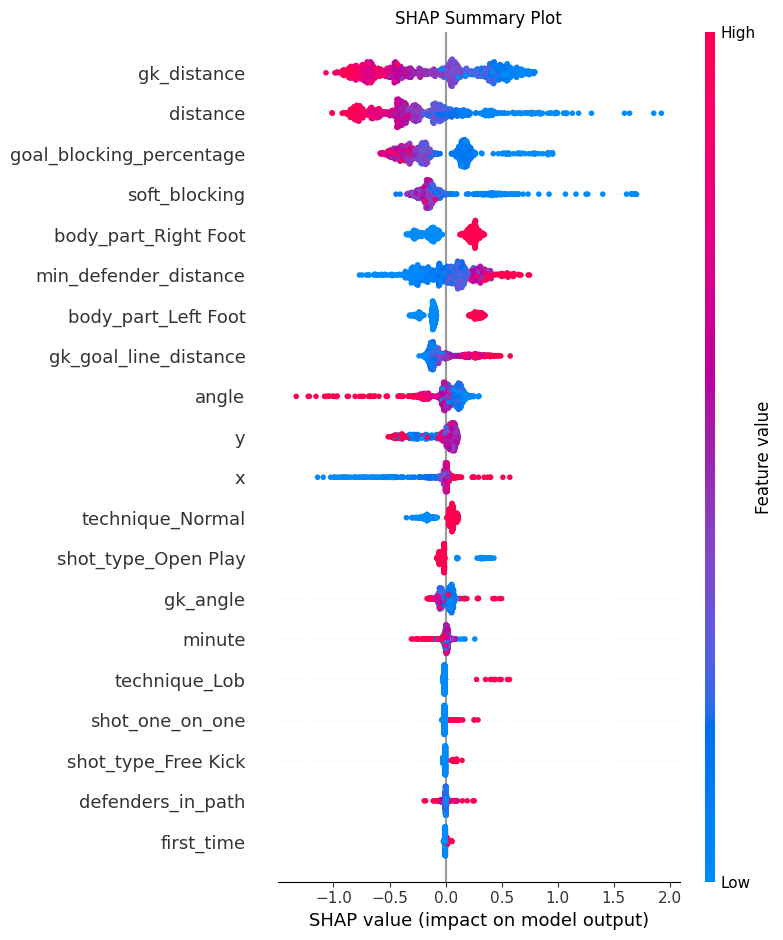

/Users/philipredford-jones/projects/football_analytics/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/philipredford-jones/projects/football_analytics/.venv/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Figure size 1000x700 with 0 Axes>

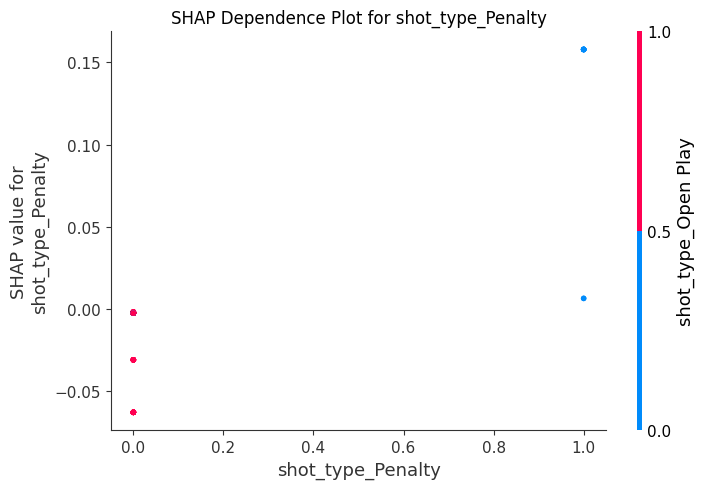

<Figure size 1000x700 with 0 Axes>

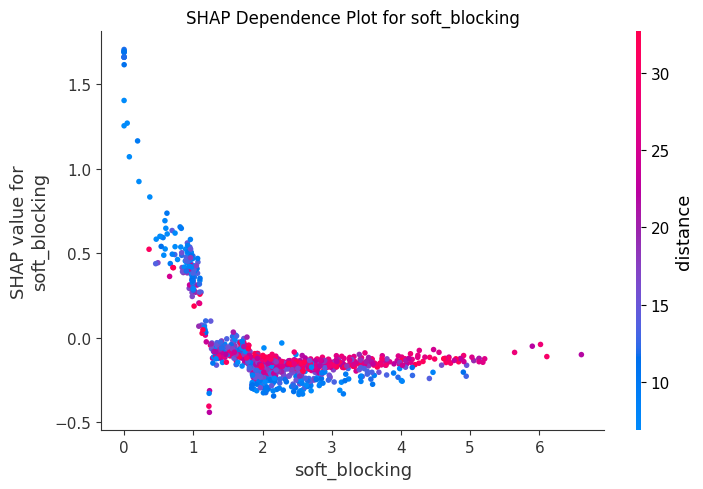

<Figure size 1000x700 with 0 Axes>

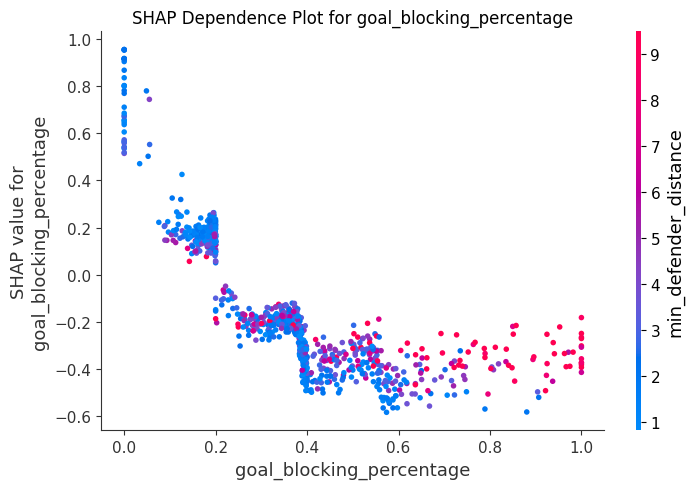

<Figure size 2000x300 with 0 Axes>

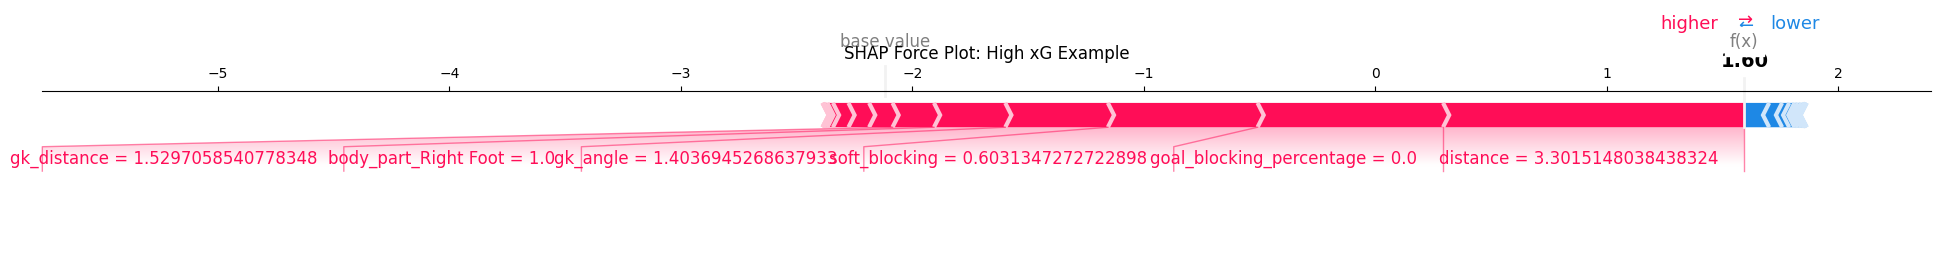

<Figure size 2000x300 with 0 Axes>

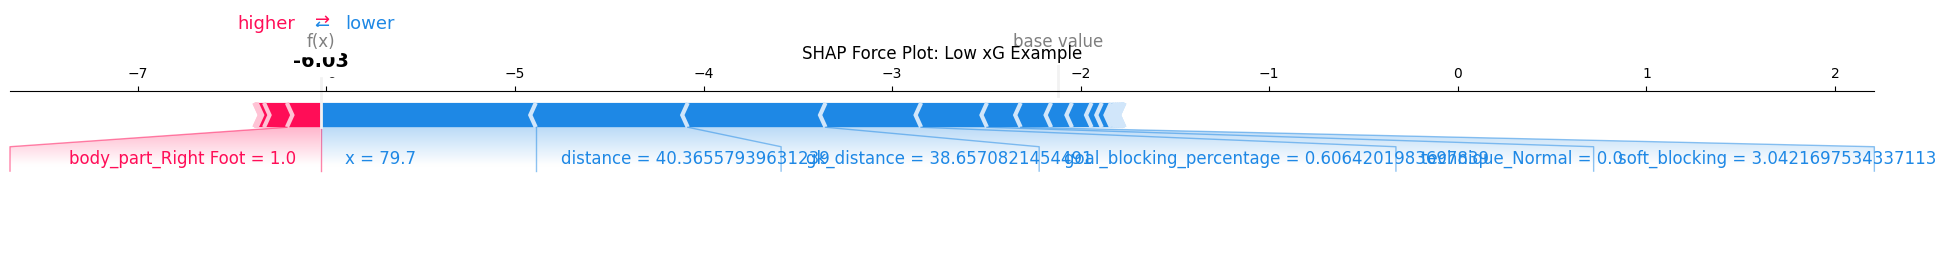

<Figure size 2000x300 with 0 Axes>

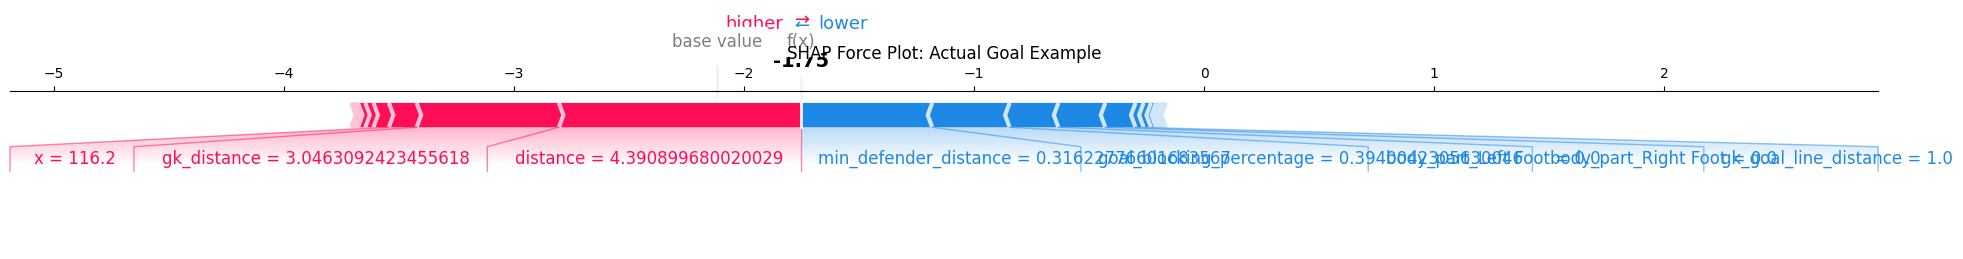

In [41]:
# Import SHAP
import shap

# Feature importance for XGBoost
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_best.feature_importances_
})
xgb_importance = xgb_importance.sort_values('Importance', ascending=False)

# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(xgb_best)

# Calculate SHAP values on a sample of the test set (for speed)
sample_size = min(1000, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_test_sample = X_test.iloc[sample_indices]
shap_values = explainer(X_test_sample)

# Create a summary plot showing the impact of each feature
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Create a summary plot showing both feature importance and effect direction
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

# Detailed dependence plots for top 3 features
# Find the indices of the top 3 features from the XGBoost importance
top_feature_indices = xgb_importance.head(3)['Feature'].values
for feature in top_feature_indices:
    plt.figure(figsize=(10, 7))
    shap.dependence_plot(feature, shap_values.values, X_test_sample, show=False)
    plt.title(f"SHAP Dependence Plot for {feature}")
    plt.tight_layout()
    plt.show()

# Force plot for a few example predictions
# High xG example
high_xg_idx = np.argmax(xgb_pred_proba[sample_indices])
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, 
                shap_values[high_xg_idx].values, 
                X_test_sample.iloc[high_xg_idx],
                matplotlib=True, show=False)
plt.title("SHAP Force Plot: High xG Example")
plt.tight_layout()
plt.show()

# Low xG example
low_xg_idx = np.argmin(xgb_pred_proba[sample_indices])
plt.figure(figsize=(20, 3))
shap.force_plot(explainer.expected_value, 
                shap_values[low_xg_idx].values, 
                X_test_sample.iloc[low_xg_idx],
                matplotlib=True, show=False)
plt.title("SHAP Force Plot: Low xG Example")
plt.tight_layout()
plt.show()

# Compare with a goal that was actually scored
goal_indices = np.where(y_test.iloc[sample_indices] == 1)[0]
if len(goal_indices) > 0:
    scored_goal_idx = goal_indices[0]
    plt.figure(figsize=(20, 3))
    shap.force_plot(explainer.expected_value, 
                    shap_values[scored_goal_idx].values, 
                    X_test_sample.iloc[scored_goal_idx],
                    matplotlib=True, show=False)
    plt.title("SHAP Force Plot: Actual Goal Example")
    plt.tight_layout()
    plt.show()

# Save the model

In [42]:
# Create models directory if it doesn't exist
models_dir = f"{os.path.abspath(os.path.join(os.getcwd(), '..'))}/models/"
os.makedirs(models_dir, exist_ok=True)

# Save the best model (XGBoost) using joblib
import joblib

# Save the trained model
xgb_model_path = os.path.join(models_dir, "xgboost_xg_model2.joblib")
xgb_best.save_model(xgb_model_path)
print(f"XGBoost model saved to: {xgb_model_path}")


# Save feature columns for later reference
feature_cols_path = os.path.join(models_dir, "feature_columns2.joblib")
joblib.dump(list(X.columns), feature_cols_path)
print(f"Feature columns saved to: {feature_cols_path}")

XGBoost model saved to: /Users/philipredford-jones/projects/football_analytics/models/xgboost_xg_model2.joblib
Feature columns saved to: /Users/philipredford-jones/projects/football_analytics/models/feature_columns2.joblib


/Users/philipredford-jones/projects/football_analytics/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:1028: UserWarning: [16:01:44] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


In [61]:
X.head()

,x,y,distance,angle,shot_one_on_one,under_pressure,first_time,minute,defenders_in_path,min_defender_distance,soft_blocking,goal_blocking_percentage,gk_distance,gk_angle,gk_goal_line_distance,body_part_Left Foot,body_part_Other,body_part_Right Foot,shot_type_Free Kick,shot_type_Open Play,shot_type_Penalty,technique_Diving Header,technique_Half Volley,technique_Lob,technique_Normal,technique_Overhead Kick,technique_Volley,game_period_First Half,game_period_First Half Ending,game_period_Opening,game_period_Second Half,game_period_Second Half Beginning
0,92.6,48.8,28.778464,0.310762,0,0,1,1,4.0,6.612866,2.341634,0.458370,28.122055,0.014877,0.5,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
1,97.6,32.4,23.654175,0.327098,0,0,0,4,3.0,4.100000,3.047391,0.553619,21.345960,0.002060,2.2,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
2,110.7,32.5,11.947385,0.678662,0,1,0,8,1.0,0.824621,1.683779,0.155096,9.985990,0.107325,0.9,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False
3,99.2,40.0,20.800000,0.000000,0,1,0,12,3.0,1.204159,2.869468,0.562650,19.602296,0.015305,1.2,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False
4,112.4,37.3,8.065358,0.341356,0,1,1,14,0.0,1.303840,1.241646,0.000000,6.700000,0.341356,0.9,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False


In [70]:
xgb_best.predict_proba(X_test)[:,1]

array([0.00648713, 0.14197253, 0.07807603, ..., 0.07692678, 0.02153437,
       0.01122681], dtype=float32)

In [72]:
X_test[X_test['shot_type_Penalty'] == True]


,x,y,distance,angle,shot_one_on_one,under_pressure,first_time,minute,defenders_in_path,min_defender_distance,soft_blocking,goal_blocking_percentage,gk_distance,gk_angle,gk_goal_line_distance,body_part_Left Foot,body_part_Other,body_part_Right Foot,shot_type_Free Kick,shot_type_Open Play,shot_type_Penalty,technique_Diving Header,technique_Half Volley,technique_Lob,technique_Normal,technique_Overhead Kick,technique_Volley,game_period_First Half,game_period_First Half Ending,game_period_Opening,game_period_Second Half,game_period_Second Half Beginning
49504,108.1,40.1,11.900420,0.008403,0,0,0,61,2.0,2.343075,0.000000,0.000000,15.376931,0.034879,0.7,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False
18685,108.0,40.0,12.000000,0.000000,1,0,0,79,1.0,11.101802,0.991151,0.198230,11.101802,0.018016,0.9,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False
44074,108.0,40.0,12.000000,0.000000,0,0,0,126,2.0,2.343075,0.000000,0.000000,15.376931,0.034879,3.0,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False
144,109.0,41.0,11.045361,0.090660,0,0,0,92,2.0,2.343075,0.000000,0.000000,15.376931,0.034879,0.0,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False
58313,108.1,40.1,11.900420,0.008403,0,0,0,94,2.0,2.343075,0.000000,0.000000,15.376931,0.034879,1.4,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37990,108.1,40.0,11.900000,0.000000,1,0,0,128,1.0,11.300442,0.997780,0.199556,11.300442,0.008849,0.6,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False
56222,108.0,40.0,12.000000,0.000000,0,0,0,4,2.0,2.343075,0.000000,0.000000,15.376931,0.034879,1.4,False,False,True,False,False,True,False,False,False,True,False,False,False,False,True,False,False
28741,108.0,40.0,12.000000,0.000000,0,0,0,23,2.0,2.343075,0.000000,0.000000,15.376931,0.034879,2.2,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False
44067,108.0,40.0,12.000000,0.000000,0,0,0,120,2.0,2.343075,0.000000,0.000000,15.376931,0.034879,3.0,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False
